In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import cv2
import pandas as pd
import functools
import ast
import pickle

In [0]:
image_data_dir = '/content/gdrive/My Drive/ImageCaptioning2/images'
label_data_dir = '/content/gdrive/My Drive/ImageCaptioning2/text'
model_save_dir = '/content/gdrive/My Drive/ImageCaptioning2/model'
weights_save_dir = '/content/gdrive/My Drive/ImageCaptioning2/weights'

In [0]:
label_df = pd.read_csv(label_data_dir + '/processed_label.csv')

In [0]:
import json

file_name = 'word_to_index.json'
with open(model_save_dir + '/' + file_name) as f:
    word_to_index = json.loads(f.read())

In [0]:
print(word_to_index['<EOS>'])
print(word_to_index['<SOS>'])

1893
8140


In [0]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [0]:
print(label_df['Encoded_Description'][0])
print(type(label_df['Encoded_Description'][0]))
label_df['Encoded_Description'] = label_df['Encoded_Description'].apply(lambda x: ast.literal_eval(x))
print(label_df['Encoded_Description'][0])
print(type(label_df['Encoded_Description'][0]))

[8140, 4872, 1729, 5702, 77, 1255, 8015, 1371, 1033, 6673, 7926, 1729, 4694, 7952, 6800, 1893]
<class 'str'>
[8140, 4872, 1729, 5702, 77, 1255, 8015, 1371, 1033, 6673, 7926, 1729, 4694, 7952, 6800, 1893]
<class 'list'>


In [0]:
with open(model_save_dir + '/image_features', 'rb') as f:
    features_dict = pickle.load(f)

In [0]:
image_names = set(list(label_df['Processed_Image_Name']))
path_dict = {image_name: image_data_dir + '/' + image_name for image_name in image_names}

In [0]:
f = open(label_data_dir + '/Flickr_8k.testImages.txt', 'r')
test_image_names = f.readlines()
f.close()

In [0]:
vocab_size = len(word_to_index) + 1
print(vocab_size)

8821


In [0]:
start_of_sentence_index = word_to_index['<SOS>']
print(start_of_sentence_index)

8140


In [0]:
print(len(test_image_names))

1000


In [0]:
latent_dim = 256
embedding_size = 100

In [0]:
encoder_y = np.zeros((vocab_size, ))
encoder_y[start_of_sentence_index] = 1

test_image_names = [img.rstrip() for img in test_image_names]
print(len(test_image_names))

def get_next_image():
  
  num_steps = len(test_image_names)
  
  for i in range(num_steps):
    test_image = test_image_names[i]
    encoder_x_train = []
    features = features_dict[test_image]
    encoder_x_train.append(features)
    yield np.asarray(encoder_x_train), test_image  

1000


In [0]:
import os
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import load_model
import numpy as np
from keras.models import Model

Using TensorFlow backend.


In [0]:
def get_weights_filename(index):
  file_name = 'model_' + str(index) + '.h5'
  return weights_save_dir + '/' + file_name

In [0]:
def build_models(load_weights_for_run = 8):
  
  encoder_input = Input(shape = (1, 4096), name = 'input_3')
  encoder_lstm = LSTM(latent_dim, return_state = True, name = 'lstm_3')
  encoder_outputs, encoder_h, encoder_c = encoder_lstm(encoder_input)
  encoder_states = [encoder_h, encoder_c]
  
  decoder_input = Input(shape = (None, ), name = 'input_4')
  decoder_input_h = Input(shape = (latent_dim, ))
  decoder_input_c = Input(shape = (latent_dim, ))
  decoder_input_states = [decoder_input_h, decoder_input_c]
  decoder_embedding_layer = Embedding(vocab_size, embedding_size, name = 'embedding_2')
  decoder_embedding_output = decoder_embedding_layer(decoder_input)
  decoder_lstm = LSTM(latent_dim, return_state = True, return_sequences = True, name = 'lstm_4')
  decoder_outputs, decoder_h, decoder_c = decoder_lstm(decoder_embedding_output, initial_state = decoder_input_states)
  decoder_output_states = [decoder_h, decoder_c]
  #decoder_dense = Dense(vocab_size, activation = 'softmax', name = 'dense_3')
  decoder_dense = Dense(vocab_size, activation = 'softmax', name = 'time_distributed_2')
  decoder_outputs = decoder_dense(decoder_outputs)
  
  encoder_model = Model(encoder_input, encoder_states)
  
  decoder_model = Model([decoder_input] + decoder_input_states, [decoder_outputs] + decoder_output_states)
  
  weights_file = get_weights_filename(load_weights_for_run)
  encoder_model.load_weights(weights_file, by_name = True)
  decoder_model.load_weights(weights_file, by_name = True)
  
  return encoder_model, decoder_model

In [0]:
weights_for_run = 20

encoder_model, decoder_model = build_models(weights_for_run)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 4096)           0         
_________________________________________________________________
lstm_3 (LSTM)                [(None, 256), (None, 256) 4457472   
Total params: 4,457,472
Trainable params: 4,457,472
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    882100      input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_4 (LS

In [0]:
eos = '<EOS>'
sos = '<SOS>'
eos_index = word_to_index[eos]

def generate_caption(input_image):
  encoder_states = encoder_model.predict(input_image)
  
  decoder_input = np.zeros((1, ))
  decoder_input[0] = word_to_index[sos]
 
  decoder_output = np.zeros((1, vocab_size))
  
  stopCondition = False
  
  input_states = encoder_states
  
  words = []
  
  while not stopCondition:
   
    decoder_output, decoder_h, decoder_c = decoder_model.predict([decoder_input] + input_states)
    
    #next_word_index = np.random.choice(np.arange(0, vocab_size), p = decoder_output.ravel())
    next_word_index = np.argmax(decoder_output.ravel())
    word = index_to_word[next_word_index]
    
    if word == eos:
      stopCondition = True
    else:
      words.append(word)
      decoder_input = np.zeros((1, ))
      decoder_input[0] = next_word_index
      input_states = [decoder_h, decoder_c]
  
  return ' '.join(words)

In [0]:
from matplotlib import pyplot as plt
import cv2
test_image_generator = get_next_image()

/content/gdrive/My Drive/ImageCaptioning2/images/2654514044_a70a6e2c21.jpg


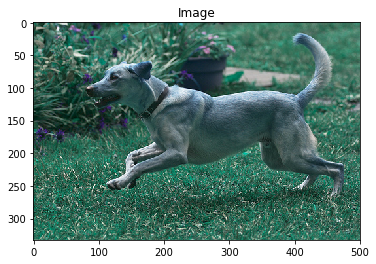

Caption: the dog is running through the grass


In [0]:
input_image, img_name = next(test_image_generator)
img1_path = path_dict[img_name]
print(img1_path)

img = cv2.imread(img1_path)


plt.imshow(img)
plt.title('Image')
plt.show()

caption = generate_caption(input_image)
print('Caption: {}'.format(caption))